# Stance Detection on Tweets using NLP Methods

Note: This tutorial consists of two separate python notebooks. This notebook is the second one. The first notebook can be found [here](TODO).  I recommend that you go through the first notebook before the second one as the second notebook builds on top of the first one.

1. First notebook: Fine-tuning BERT models: include standard BERT and domain-specific BERT
- TODO: add link

2. Second notebook (this one): Promoting large language models (LLMs): include ChatGPT, FLAN-T5 and different prompt types (zero-shot, few-shot, chain-of-thought)
- TODO: add link


## Getting Started: Overview, Prerequisites, and Setup

**Objective of the tutorial**: This tutorial will guide you through the process of stance detection on tweets using two main approaches: fine-tuning a BERT model and using large language models (LLMs).

**Prerequisites**: 

- If you want to run the tutorial without editting the codes but want to understand the content
  - Basic Python skills: functions, classes, pandas, etc.
  - Basic ML knowledge: train-validation-test split, F1 score, forward pass, backpropagation etc.

- Familiarity with NLP concepts is a plus, particularly with transformers. However, if you're not familiar with them, don't worry. I'll provide brief explanations in the tutorial, as well as links to fantastic in-depth resources throughout the text.

**Acknowledgements**

- While the application of LLMs on stance detection is my own work, some part of this tutorials, e.g., GPT-3, are inspired by the following tutorials. Some of the figures are also modified from the images in these tutorials. I highly recommend you check them out if you want to learn more about LLMs.
  - https://jalammar.github.io/illustrated-gpt2/#part-1-got-and-language-modeling
  - https://jalammar.github.io/how-gpt3-works-visualizations-animations/

**Setup**

1. Before we begin with Google Colab, please ensure that you have selected the GPU runtime. To do this, go to `Runtime` -> `Change runtime type` -> `Hardware accelerator` -> `GPU`. This will ensure that the note will run more efficiently and quickly.

2. Now, let's download the content of this tutorial and install the necessary libraries by running the following cell.

In [2]:
from os.path import join
ON_COLAB = False
if ON_COLAB:
  !git clone https://github.com/yunshiuan/prelim_stance_detection.git
  !python -m pip install pandas datasets openai accelerate transformers transformers[sentencepiece] torch==1.12.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html emoji -q
  %cd /content/prelim_stance_detection/scripts
else:
  %cd scripts

/home/sean/prelim_stance_detection/scripts


In [3]:
# a helper function to load images in the notebook
from PIL import Image as PILImage
from pathlib import Path
from IPython.display import display, SVG

from parameters_meta import ParametersMeta as par
PATH_IMAGES = join(par.PATH_ROOT, "images")

def display_resized_image_in_notebook(file_image, scale=1, use_default_path=True):
    """Display an image in a notebook."""
    # - https://stackoverflow.com/questions/69654877/how-to-set-image-size-to-display-in-ipython-display
    if use_default_path:
        file_image = join(PATH_IMAGES, file_image)
    image = PILImage.open(file_image)
    display(image.resize((int(image.width * scale), int(image.height * scale))))    

****

## Two Stance Detection Paradigms

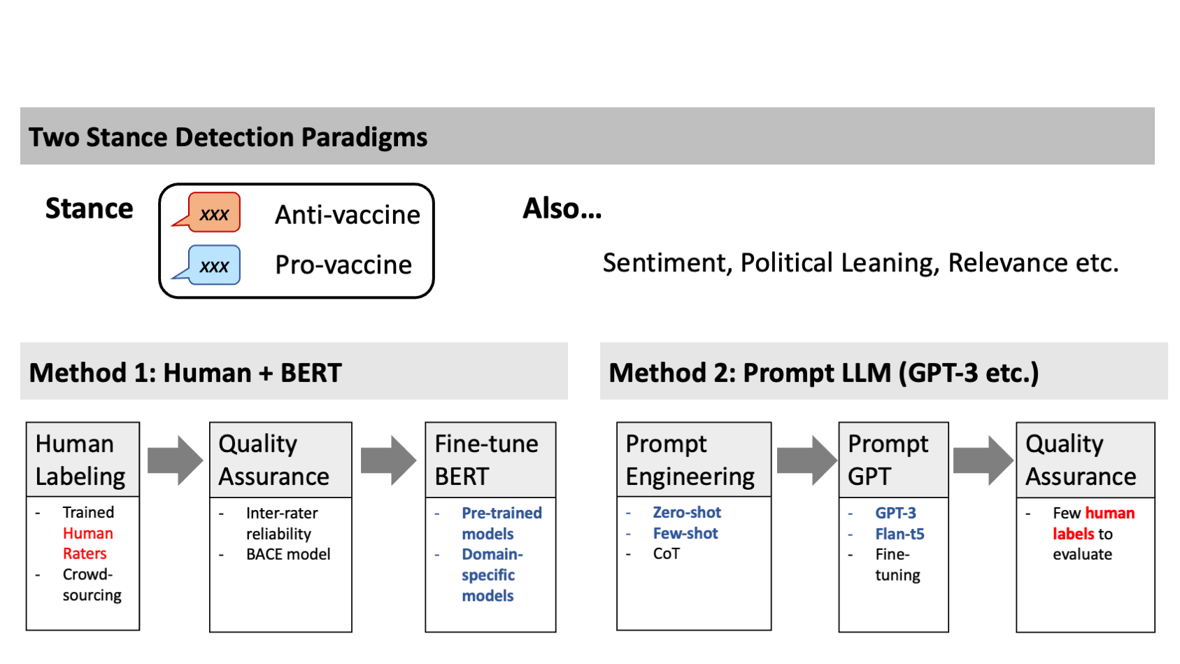

In [4]:
display_resized_image_in_notebook("stance_detection_two_paradigm.png", 0.7)

In this tutorial, we are exploring two different paradigms for stance detection: 1) fine-tuning a BERT model, and 2) prompting large language models (LLMs) like ChatGPT. 

Fine-tuning a BERT model involves training the model on a specific task using a labeled dataset, which adapts the model's pre-existing knowledge to the nuances of the task. This approach can yield strong performance but typically requires a substantial amount of labeled data for the target task.

On the other hand, prompting LLMs involves crafting carefully designed input prompts that guide the model to generate desired outputs based on its pre-trained knowledge. This method does not require additional training, thus significantly reducing the amount of labeled data needed. Note that some labeled data is still required to evaluate the performance.

In this second tutorial, we will focus on the second paradigm: prompting LLMs. We will explore two classes of LLMs: ChatGPT and FLAN-T5. We will also explore different prompt types: zero-shot, few-shot, and chain-of-thought.

> For the first approach, please see my first tutorial [here](TODO).

****

# Paradigm 2: Using Large Language Models (LLMs) for Stance Detection

Large Language Models (LLMs) like GPT-3 are gaining significant attention in recent years. These models are designed to understand and generate human-like text by learning from vast amounts of data. In the context of stance detection, LLMs can be used to classify text based on the stance towards a particular topic.


> Strictly speaking, BERT is also a type of LLMs. The "LLMs" covered in this notebook actually refer to a special type of LLMs, the "generative models", which means they can be used to generate text. In contrast, BERT is a discriminative model, which means it can only be used to classify text. I am using the term "LLMs" to refer to these generative models for the sake of simplicity.

Although there are many variants of LLMs, I will explain LLMs with GPT-3 as an example. Later in this tutorial, I will then point out the differences between GPT-3 and other LLMs, such as ChatGPT, FLAN-T5, etc.

Because GPT-3 and BERT are both based on transformers, they share many similarities. I will explain GPT-3 by contrasting it with BERT, assuming that you alreadt know how BERT works, which is covered in the first notebook.

## Contrast GPT-3 with BERT

### Model Architecture: Encoder vs. Decoder 

Both BERT and GPT-3 are transformer-based models, which means they both employ self-attention layers to learn the relationships between words in a text. However, they utilize self-attention layers differently.

Notably, in their model architecture, BERT uses "encoder blocks," while GPT-3 employs "decoder blocks." Due to this distinction, BERT is often referred to as an "encoder" model, while GPT-3 is commonly known as a "decoder" model.



<u>**Encoder (BERT)**</u>

In simple terms, an encoder model like BERT encodes an input sequence into a fixed-length vector (after 12 self-attention layers for BERT). This vector, or, representation, is then used to classify the input sequence.

Let's look at a concrete example from the Abortion dataset. 

> "<u>_It's so brilliant that #lovewins - now extend the equality to women's rights #abortionrights_</u>"


Recall from the previous tutorial that when an encoder model like BERT processes a sentence, it utilizes bidirectional context to accurately capture the meaning of the sentence. Afterward, we can fine-tune the model using a labeled dataset to adapt it to our specific task.

<u>**Decoder (GPT-3)**</u>

On the other hand, a decoder model like GPT-3 are designed to **generate** (rather than encode) a sequence from left to right, one token at a time. If we provide a partially complete sequence of words (also known as "prompt") to GPT-3, it will help complete the sequence (also known as "**conditional text generation**"). 

So, if we rephrase the same sentence into the following format, and provide GPT-3 with this partially complete sequece (also known is "**<u>prompt</u>**"), we can use GPT-3 to generate its prediction of the stance based on the prompt.

Let's rephrase the sentence into the following "**<u>prompt</u>**": 

> "What is the stance of the tweet below with respect to 'Legalization of Abortion'? Please use exactly one word from the following 3 categories to label it: 'in-favor', 'against', 'neutral-or-unclear'. Here is the tweet: '<u>_It's so brilliant that #lovewins - now extend the equality to women's rights #abortionrights_</u>.' The stance of the tweet is: "

With this rephrased sequence, we convert the stance detection task - a classification task, into a text generation task. We can then use GPT-3 to generate the stance of the tweet.

Note that GPT-3, like BERT, still uses self-attention layers to learn the relationships between words. The critical distinction is that when GPT-3 generates a sequence, it can only look at the words before the word to be generated (in this example, the prompt), rather than the bidirectional context like BERT. 

The primary difference in the usege of self-attention mechanism is shown in the following figure. On the left, we have the encoder model (BERT), where the self-attention layers are bidirectional, i.e., covering both the left and right context. 

On the right, we have the decoder model (GPT-3), where the self-attention layers are unidirectional, i.e., only covering the left context when evaluating the word to predict.

In [1]:
display_resized_image_in_notebook("encoder_vs_decoder.png",0.3)

NameError: name 'display_resized_image_in_notebook' is not defined

> Another important difference between BERT and GPT-3 is the size of the context they can handle. BERT uses a context of 512 tokens, while GPT-3 can handle a much larger context depending on the specific model variant, with the largest version handling up to 4097 tokens. This means that GPT-3 can take into account a larger number of words when capturing the meaning of a word, which allows GPT-3 to consider more context surrounding a word and potentially leads to better understanding and generation capabilitie

### Different Pre-training Methods

Because BERT and GPT-3 are different types of transformer models (encoder vs. decoder), they use different pre-training methods.

<u>**BERT**</u>

As mentioned in the [previous tutorial](TODO), BERT is pre-trained using the 1) masked language modeling task and the 2) next sentence prediction task. These tasks enable the BERT model to learn the relationships between words. However, these tasks alone is not aligned with a classification task like stance detection, which is why we need to fine-tune BERT using a labeled dataset to adapt it to our specific task. 

<u>**GPT-3**</u>

In contrast, GPT-3 is pre-trained using the <u>**unidirectional language modeling task**</u>. In this task, the model is tasked with predicting the next word in a sequence, given the previous words in the sequence.

The animation below shows how GPT-3 is pre-trained using this task. In the example, the partially complete sequence is "a robot must", and the model is tasked with predicting the next word "obey" based on the previous words. This pretraining task enables the GPT-3 model to predict the stance of a given prompt with the need of fine-tuning (more on this later).

<img src="images/gpt3_pretraining.gif">

### Model Size

In addition to the differences in their model architecture, a crucial distinction between BERT and GPT-3 lies in their scale. GPT-3 primarily derives its power from its immense model size and the substantial amount of data utilized for pre-training.

While BERT indeed boasts a massive number of model parameters (hundreds of millions), GPT-3 surpasses it with an even more colossal number of parameters, reaching hundreds of billions! 

Below is a table showing the number of parameters for different LLMs. As you can see, GPT-3 has about 500 times more parameters than the largest BERT model.

Here is the reordered table as requested:

| Model Variant | Number of Parameters | Transformer Layers | Attention Heads | Hidden Size |
|---------------|----------------------|--------------------|-----------------|-------------|
| BERT-Large    | 340 million          | 24                 | 16              | 1024        |
| GPT-3         | 175 billion          | 96                 | 96              | 12288       |


> There are different variants of GPT-3 and different variants of BERT, with different number of layers, hidden size, and attention heads etc. Here, I am using the largest variant of both models for comparison.

### Pre-Traing Data Size

Because GPT-3 has a much larger number of parameters than BERT, it also requires a much larger corpus of text to pre-train. 

Specifically, GPT-3 is trained on about <u>**400 billion tokens**</u>, while BERT is trained on about <u>**3.3 billion tokens**</u>. This means that GPT-3 has about access to about 100 times more information than BERT, which can lead to better performance.

- BERT's training data: English Wikipedia + about 11k books = about 2.5 billion English words = 3.3 billion tokens
- GPT-3's training data: English Wikipedia + books + webpages crawled from the internet since 2008 with about 1 trillion words = about 400 billion tokens

> Note: Because BERT is trained on English corpus, and GPT-3 is trained on multiple languages, we can't directly compare the number of the words. Instead, we can compare the number of tokens after tokenization. Here, the tokenzier is the Byte Pair Encoding (BPE) method, which is the tokenizer used by GPT-3. If you want to know more about this tokenizer, I recommend this tutorial.: https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt

### The necessity of fine-tuning and labeled data

The role of fine-tuning in BERT and GPT-3 differs significantly.

As mentioned earlier, after the pre-training phase, BERT requires fine-tuning on specific tasks of interest (such as stance detection) using labeled data. The reason for this is that BERT is pre-trained on a masked language modeling task and a next sentence prediction task, which are not directly related to stance detection.

In contrast, GPT-3 is pre-trained on the unidirectional language modeling task, which enables it to directly generate a prediction for any given task of interest. In our use case, this means that using ahe GPT-3 model for stance detection task does not necessarily require fine-tuning with labeled data. This implication is huge as collecting labeled data is often a time-consuming and expensive process.

> Note: While it is not necessary for the model to perform well on a given task without fine-tuning on labeled data (see the prompting section below), OpenAI does offer [the option to fine-tune](https://platform.openai.com/docs/guides/fine-tuning) the GPT-3 model using labeled data,  Note that, however, fine-tining the GPT-3 model and using a fine-tuned model can be expensive. Please see the [OpenAI's pricing page](https://openai.com/pricing) for more details.

#### The Potential of Prompting

Because GPT-3 model is pre-trained in a way to predict the next word given a sequence (the "prompt"), it matter critically what the actual prompt is.

For instance, the example earlier demonstrates a "<u>zero-shot prompt</u>", which asks GPT-3 for stance prediction without providing any example tweets.


> "What is the stance of the tweet below with respect to 'Legalization of Abortion'? Please use exactly one word from the following 3 categories to label it: 'in-favor', 'against', 'neutral-or-unclear'. Here is the tweet: '<u>_It's so brilliant that #lovewins - now extend the equality to women's rights #abortionrights_</u>.' The stance of the tweet is: "

The name <u>zero-shot prompt</u> comes from the fact that no example tweets are given, and GPT-3 is expected to generate the stance based on the prompt alone.

Prompt choice significantly impacts the model's performance, an I will dedicate a separate section below to discuss different types of prompts and their implications.

### Conclusion: GPT-3 vs. BERT on stance detection

In summary, BERT and GPT-3 are both powerful transformer-based models, but with significant differences in their architecture, pre-training methods, model size, and use of fine-tuning. 

BERT, an encoder model, relies on bidirectional context and fine-tuning to perform well on specific tasks, whereas GPT-3, a decoder model, leverages unidirectional context, massive model size, and the art of prompting to perform a wide range of tasks without the need for fine-tuning.

The choice between BERT and GPT-3 for a specific task depends on several factors, such as the availability of labeled data, computational resources, and the desired level of customization. 

**Computational Resource**

Training and prompting a large model like GPT-3 requires powerful GPUs and a significant amount of memory. However, you don't need a powerful computer to use GPT-3. GPT-3 can be used directly through OpenAI's API, making it more accessible to users without high-performance hardware through [OpenAI's API](https://platform.openai.com/docs/api-reference/completions/create), which handles the computational load for you. In contrast, BERT is much smaller, and can be trained, fine-tuned, and loaded on modern cunsumer-level hardware.

**Monetary Cost**

Using the OpenAI's API comes with its own monetary cost, as the usage of the API is billed based on the number of tokens processed, and GPT-3's large model size can result in higher costs for extensive usage. That said, the cost is considered low. For the 933 tweets considered in this tutorial, the cost for using ChatGPT (an extension of the GPT-3 model) with zero-shot prompting is about $0.39 and $0.65 with few-shot prompting (more below). On the other hand, fine-tuning BERT may require more time and effort to train but can run with low monetary cost if you have the necessary hardware.

**Desired Level of Customization and the Need of Labeled Data**

BERT is often more suitable for tasks that require a deeper understanding of context and benefit from fine-tuning on domain-specific labeled data. 

On the other hand, GPT-3 is a powerful option for tasks that can leverage its vast knowledge and benefit from zero-shot or few-shot learning approaches without large amounts of labeled data. For example, when labeled data is scarce or the task is more general in nature. GPT-3 may perform well across various tasks without fine-tuning can be advantageous.

**Open-source vs Closed-source**

While BERT is an open-source model, GPT-3 is a closed-source model. This means that you can't access the source code of GPT-3, and you can't train your own GPT-3 model or modify the mode (and you also have to pay for the usage). However, not all LLMs are closed-source. For example, you can train your own GPT-2 model using the [Hugging Face's implementation](https://huggingface.co/transformers/model_doc/gpt2.html). In this tutorial, I will also show you another state-of-the-art open-source LLM, the [FLAN-T5 model](https://huggingface.co/docs/transformers/model_doc/FLAN-T5), which is suitable for stance detection tasks.

Now that we have a better understanding of the differences between BERT and GPT-3, let's dive deeper into prompting techniques for large language models in the next section.

****

## Prompting Techniques for LLMs

To effectively utilize LLMs like ChatGPT-3 for stance detection, we can employ various prompting techniques that guide the model's response without the need for fine-tuning.

> If you want to learn more about prompting techniques, I recommend this online tutorial: https://learnprompting.org/docs/intro


### Zero-shot Prompting

In the zero-shot prompting technique, for stance detection, GPT-3 is provided with a task description and with the tweet of interest, without any specific examples.

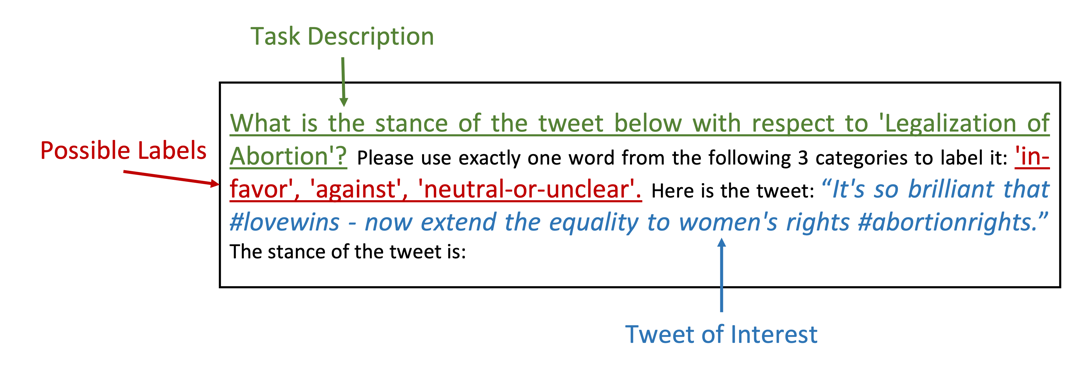

In [158]:
display_resized_image_in_notebook("prompt_zero_shot_v1.png",0.3)

We can further improve this prompt with the definition of each stance category. Note that when human annotators are asked to label a tweet, they are usually provided with the definition of each stance category. To this end, I extract the definitions of each stance category from "codebook" of the [SemEval 2016 Task 6 dataset](https://alt.qcri.org/semeval2016/task6/data/uploads/stance-question.pdf) and include them in the prompt.

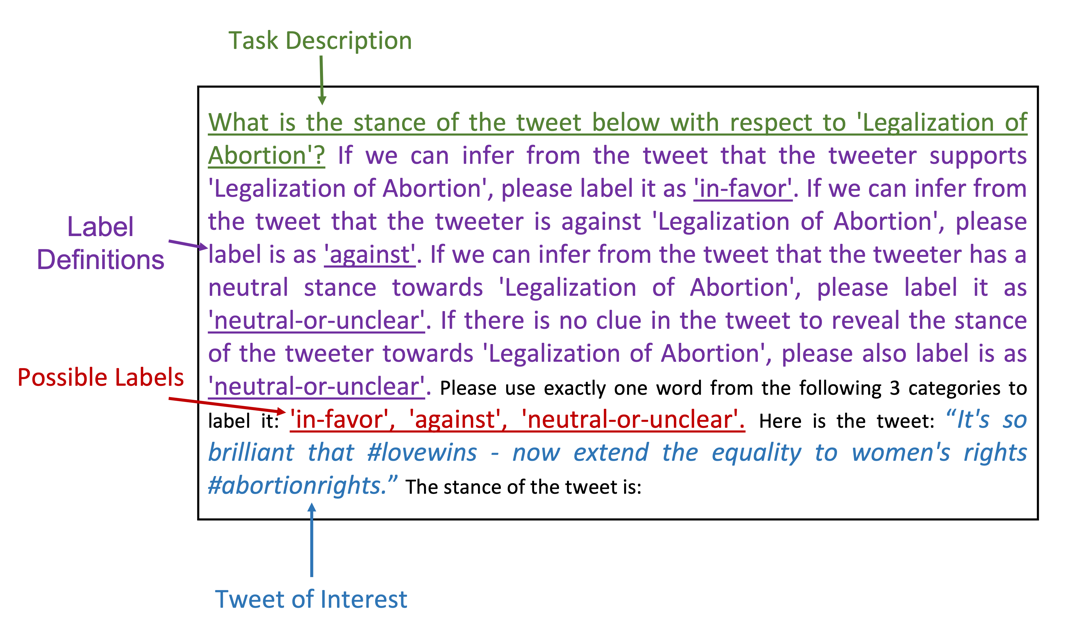

In [159]:
display_resized_image_in_notebook("prompt_zero_shot_v2.png",0.3)


### Few-shot Prompting

The few-shot prompting technique involves providing the LLM with a small number of examples to guide its response. This allows the model to learn from the provided examples and adapt its output accordingly. Below is an example of a few-shot prompt for stance detection, with 1 example tweet for each stance category.

Note that I append the example tweets to the zero-shot prompt I made above.

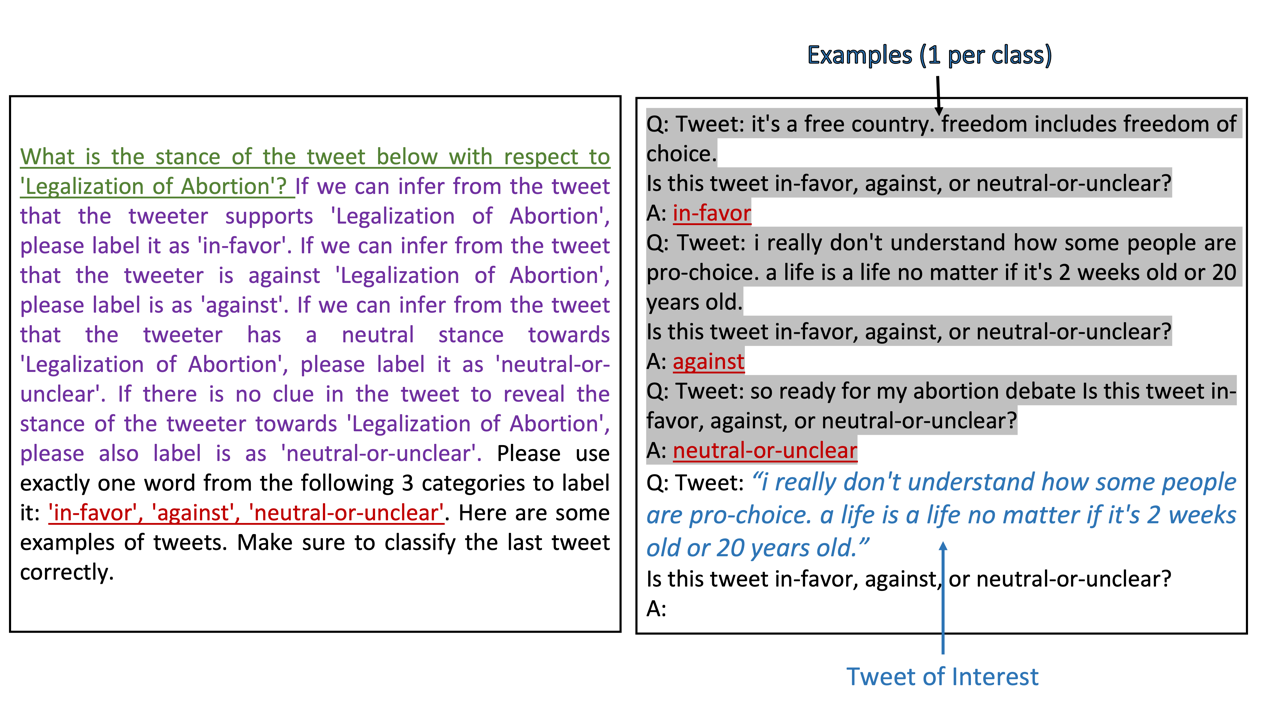

In [160]:
display_resized_image_in_notebook("prompt_few_shot.png",0.3)

> Note: It may sound trivial, but when evaluating the performance of the LLMs with few-shot prompting, it is important to make sure that the examples provided to the model are not included in the test set to avoid data leakage. 

Note: A comprehensive evaluattion of the zero-shot and few-shot performance of GPT-3 is available in [Brown, T. et al (2020)](https://arxiv.org/abs/2005.14165).


### Zero-shot Chain-of-thoughts (CoT) Prompting

By appending the words "let's think step-by-step" to the zero-shot prompt, we can ask GPT-3 to generate a chain of thoughts that lead to the stance prediction. This has been shown to improve the performance of LLMs in task that involves reasoning. This particular prompt is called zero-shot chain-of-thoughts (CoT) prompting.

One example task where the zero-shot chain-of-thoughts prompting technique has been shown to be effective is in task involves numerical reasoning. For instance, in the example below,, GPT-3 is able to generate a chain of thoughts that lead to the correct answer, as opposd to the standard zero-shot prompting technique, which fails to generate the correct answer. 

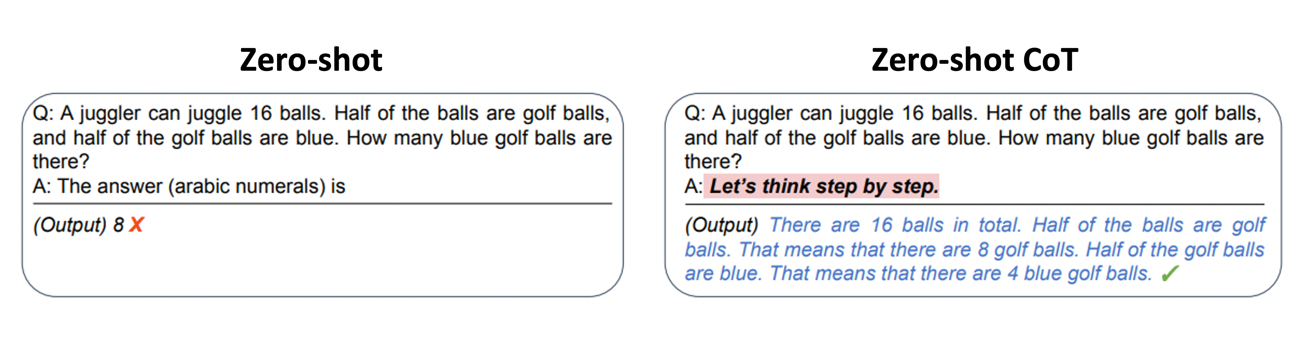

In [161]:
display_resized_image_in_notebook("prompt_cot_math.png",0.3)

> The zero-shot CoT is proposed by [Kojima, T. et al (2022)](https://arxiv.org/pdf/2205.11916.pdf), and the figure is also modified from their paper.

Since stance detection often requires reasoning, it makes sense to consider zero-shot CoT prompting technique for our task.

Below is an example of a zero-shot chain-of-thoughts prompt for stance detection. Notice that I append the words "let's think step-by-step" to the zero-shot prompt I made above with minor modifications.

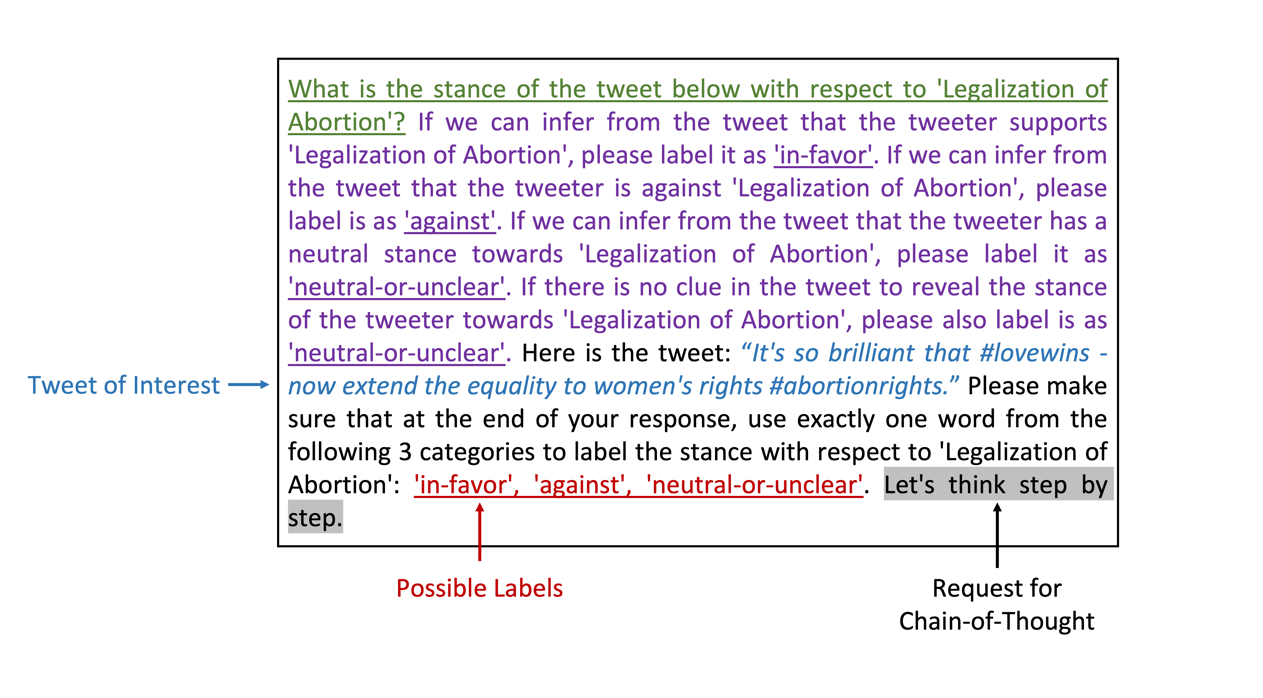

In [162]:
display_resized_image_in_notebook("prompt_cot.png",0.3)

One important caveat about the chain-of-thought (CoT) prompt is that, according to [Wei et al. (2022)](https://arxiv.org/pdf/2201.11903.pdf?trk=public_post_comment-text), CoT tends to yield performance gains only when used with larger models of around 100 billion parameters or more. For smaller language models, the CoT prompt might actually harm the performance, as the model may generate incorrect chains of thoughts, leading to an inaccurate prediction.

> Note: The original chain-of-thoughts (CoT) prompt includes some examples of reasoning in the prompt, like the few-shot prompt. However, in this tutorial, for the sake of simplicity, I will only use the zero-shot CoT prompt. I will also use the term "CoT" to refer to the zero-shot CoT prompt.

****

## Two state-of-the-art LLMs: ChatGPT and FLAN-T5

Before I move on to the programming part, I want to introduce two state-of-the-art LLMs that are suitable for stance detection tasks: ChatGPT and FLAN-T5.

### ChatGPT

[ChatGPT](https://openai.com/blog/chatgpt) (`gpt-3.5-turbo`) is an extension of the GPT-3 model. One significant advantage of ChatGPT, compared to GPT-3 (`gpt-3-davinci`, the most powerful variant), is its lower cost. According to [OpenAI's pricing page](https://openai.com/pricing/), using ChatGPT costs $0.002 per 1k tokens (approximately 750 English words, including both words in the prompt and generated sequence), which is about 10 times cheaper than GPT-3 at $0.02 per 1k tokens (as of 04/22/2023).

Besides the difference in pricing, the main distinction between ChatGPT and GPT-3 lies in their training approaches. While both models are pre-trained using the next word prediction task, ChatGPT is further trained with human feedback to generate more coherent and contextually relevant responses in conversational settings. This additional training is crucial since ChatGPT is designed to function as a chatbot, expected to provide responses that are coherent and contextually relevant to the user's input.

Finally, it is worth noting that there is a newer, more powerful variant of the model called [GPT-4](https://openai.com/research/gpt-4). This advanced version has demonstrated remarkable performance on various sophisticated exams, including AP exams, GRE tests, and the Law Bar Exam, among others. However, due to the higher cost and accessibility (as there is currently a waitlist to use it), this tutorial will focus on using `gpt-3.5-turbo`. 


#### Fine-tuning with human feedback in ChatGPT

During the fine-tuning of ChatGPT, a technique called <u>**reinforcement learning from human feedback (RLHF)**</u> is critical. The goal is to have ChatGPT generate texts that sound "human-like" in a conversation. This method includes making an initial dataset with the help of human AI trainers (who give conversations or answers to different prompts). Then, these human trainers compare and rank several responses created by Chat-GPT-3.5. Using these rankings, a reward model is trained to predict human's ranking. The ChatGPT model is then optimized to maximize the reward evluated by the reward model. By repeatedly using human feedback, the model gets better and its answers become more human-like.

The diagram below (copied from [OpenAI's post on ChatGPT](https://openai.com/blog/chatgpt)) shows the process of fine-tuning ChatGPT with RLHF.

> The details of the RLHF method is beyond the scope of this tutorial. If you are interested in learning more about RLHF, I recommend reading [OpenAI's post on ChatGPT](https://openai.com/blog/chatgpt).

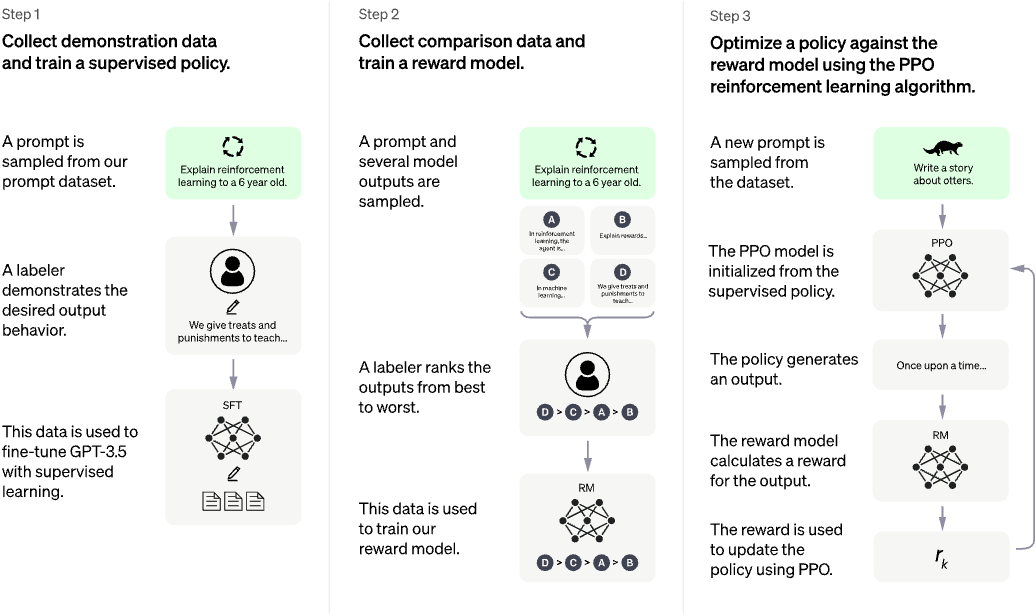

In [6]:
display_resized_image_in_notebook("chatgpt_finetuning.png",scale = 1)


### Open-source model FLAN-T5

The [FLAN-T5](https://huggingface.co/docs/transformers/model_doc/FLAN-T5) model is another LLM. A significant advantage of FLAN-T5 is that it is open-source, meaning that it is free to use (if you have access to GPUs)! This is in contrast to ChatGPT, which is a proprietary model.  

It is based on the T5 (Text-to-Text Transfer Transformer) architecture developed by Google Research. Like GPT-3, FLAN-T5 also has the decoder component, which enables it to generate sequence given a prompt.

#### Instruction Fine-tuning

One critical difference between FLAN-T5 and GPT-3 is the "instruction fine-tuning" procedure. After pre-training, FLAN-T5 is fine-tuned with over 1.8k text-to-text tasks, like summarization, translation, question-answering, among many, where data are fed into the model in `(input_text, output_text)` pairs to predict the output text given the input text.

This means that FLAN-T5 is more suitable for instruction-based question-answering tasks, such as stance detection, but is less suitable for long-form text generation tasks, such as story generation.

Below is a diagram of how FLAN-T5 is fine-tuned. 

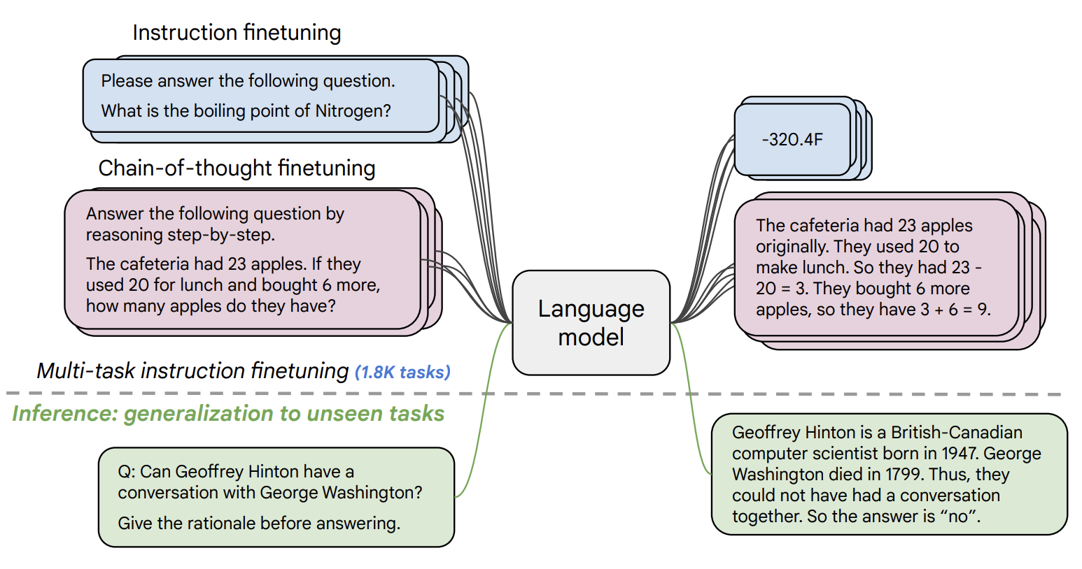

In [164]:
display_resized_image_in_notebook("flan_t5_xxl.png",0.7)

>  Note for advanced readers: The intricate details of the FLAN-T5 model architecture and training procedure are beyond the scope of this tutorial. If you are interested in learning more about FLAN-T5, I recommend reading the [blog post on T5](https://towardsdatascience.com/t5-text-to-text-transfer-transformer-643f89e8905e). Although the blog post is about T5 model and not FLAN-T5 model, T5 model is the foundation of the FLAN-T5 model. Unlike GPT-3, a pure decoder model, FLAN-T5 is a "encoder-decoder model", which means it has both the encoder and the decoder. Because of the encoder component, FLAN-T5 is not pre-trained with the next word prediction task like GPT-3. Instead, FLAN-T5 is pre-trained using the "denoising autoencoder framework", which involves reconstructing the original input from a corrupted version of it.  For curious readers who are eager to learn more, please check out the [paper](https://arxiv.org/pdf/2210.11416.pdf?trk=public_post_comment-text).

### Critical Distinctions between ChatGPT and FLAN-T5

#### Closed-source vs. Open-source

ChatGPT is a closed-source proprietary model developed by OpenAI, and using it comes with costs with API access. The implementation details and source code are not openly available, which limits users' ability to modify or understand the underlying workings of the model. On the other hand, FLAN-T5 is an open-source model, which means it is free to use, and the source code is publicly available for anyone to explore, use, and modify as needed.

#### Use case

ChatGPT focuses on improving general conversational abilities and controllability and is fine-tuned with human feedback, while FLAN-T5 is designed to handle a wide range of short question-answering NLP tasks and is fine-tuned on text-to-text tasks. As a result, FLAN-T5 may be good at short question-answering task, but may not be as effective as ChatGPT for tasks that require longer responses, such as writing an essay.

#### Model size

While OpenAI has not released the exact model size of ChatGPT, the GPT-3 model that is built upon has 175 billion parameters. On the other hand, the larges variant of FLAN-T5 (`flan-t5-xxl`) has about 11 billion parameters. The difference in model size entails that ChatGPT may capture more subtle meanings in language.

| Model Variant | Number of Parameters |
|---------------|----------------------|
| BERT-Large    | 340 million          |
| FLAN-T5-Large | 780 million          |
| FLAN-T5-XXL   | 11 billion           |
| ChatGPT-3.5   | >175 billion (approx.)|


> Note: FLAN-T5, like BERT, also comes in different variants, with different number of parameters. While FLAN-T5-XXL is the most powerful variant, it can not be run on Google Colab due to GPU memory limitations. In this tutorial, we will prompt the `flan-t5-large` variant. I have prompt the `flan-t5-xxl` variant elsewhere and upload the predictions so you can still view and evaluate the performance. 

****


## Programming Exercise: Implementing Stance Detection with FLAN-T5 and ChatGPT

Now that we have a basic understanding of ChatGPT and FLAN-T5, it's time to explore them through hands-on programming exercises in the context of stance detection on the Abortion dataset, which we used in the previous tutorial with BERT. These activities will allow you to gain some practical experience with both models, helping you to use them effectively for various NLP tasks while also revealing their differences in performance and implementation.

Don't worry if you're not an expert yet — let's just dive in and learn by doing as we implement stance detection using ChatGPT and FLAN-T5 and.


## Read and Preprocess the Raw Data

Note that I am using the same preprocessed procedure as I did when I fine-tuned BERT in my previous tutorial, including removing retweet tags etc.

If you are interested in learning more about the preprocessing procedure, please refer to the previous tutorial.

In [10]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from os.path import join

from data_processor import SemEvalDataProcessor
from utils import convert_time_unit_into_name, get_parameters_for_dataset, glob_re, list_full_paths, creat_dir_for_a_file_if_not_exists, check_if_item_exist_in_nested_list, get_dir_of_a_file,func_compute_metrics_sem_eval,partition_and_resample_df, process_dataframe, tidy_name


/home/sean/miniconda3/envs/prelim/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# set up 
SEED = 42
TOPIC_OF_INTEREST = "Abortion"
DATASET = "SEM_EVAL"
par = get_parameters_for_dataset(DATASET)

PATH_OUTPUT_ROOT = join(par.PATH_RESULT_SEM_EVAL, "llm")

In [168]:

# preprocess the data
sem_eval_data = SemEvalDataProcessor()
sem_eval_data.preprocess()

df_processed = sem_eval_data._read_preprocessed_data(topic=TOPIC_OF_INTEREST).reset_index(drop=True)
# save the partitions (train, dev, test) for later use
df_partitions = sem_eval_data.partition_processed_data(seed=SEED,verbose=False)

In [169]:
df_processed.head()

,ID,tweet,topic,label,partition
0,2312,i really don't understand how some people are ...,Abortion,AGAINST,train
1,2313,let's agree that it's not ok to kill a 7lbs ba...,Abortion,AGAINST,train
2,2314,@USERNAME i would like to see poll: how many a...,Abortion,AGAINST,train
3,2315,democrats are always against 'personhood' or w...,Abortion,AGAINST,train
4,2316,@USERNAME 'if you don't draw the line where i'...,Abortion,NONE,train


Let's look at the distribution of the stance labels across the training, testdation, and testing sets.

In [170]:
# add a "count" column to count the number of tweets in each partition
df_label_dist = df_partitions[df_partitions.topic == TOPIC_OF_INTEREST].value_counts(['partition','label']).sort_index()
df_label_dist

partition  label  
test       AGAINST    188
           FAVOR       46
           NONE        45
train      AGAINST    267
           FAVOR       83
           NONE       130
vali       AGAINST     67
           FAVOR       21
           NONE        32
dtype: int64

Critically, because we are using the LLMs without fine-tuning, we don't need the training set. We will only use the validation and testing sets for evaluation. The validation set can be used to choose the right prompt, and the testing set is used to evaluate the final model.

From a pratical point of view, this greatly reduces the amount of the labeled data required.

# Create the Prompts

Let's create the prompts for the stance detection task. We will use the following three prompts: zero-shot, few-shot (1 example per class), and zero-shot chain-of-thought (CoT) prompts.

In [171]:
%load_ext autoreload
%autoreload 2
from gpt_data_processor import SemEvalGPTDataProcessor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Zero-shot prompt

In [172]:
# zero-shot (k = 0)
VERSION_PROMPT = "zero_shot"

In [173]:
gpt_data_processor = SemEvalGPTDataProcessor(version_prompt = VERSION_PROMPT, topic=TOPIC_OF_INTEREST)
# the prompt, which is the input to the LLMs
df_input_text = gpt_data_processor.embed_prompt(file_output=None, write_csv=False,
                                                return_df=True)

In [174]:
df_input_text.head()

,ID,tweet,topic,label,partition,tweet_embedded
0,2312,i really don't understand how some people are ...,Abortion,AGAINST,train,What is the stance of the tweet below with res...
1,2313,let's agree that it's not ok to kill a 7lbs ba...,Abortion,AGAINST,train,What is the stance of the tweet below with res...
2,2314,@USERNAME i would like to see poll: how many a...,Abortion,AGAINST,train,What is the stance of the tweet below with res...
3,2315,democrats are always against 'personhood' or w...,Abortion,AGAINST,train,What is the stance of the tweet below with res...
4,2316,@USERNAME 'if you don't draw the line where i'...,Abortion,NONE,train,What is the stance of the tweet below with res...


Let's look at one example of the zero-shot prompt. As you can see, the tweet of interest is now embedded in the prompt.

In [175]:
print("tweet:\n{}\n".format(df_input_text["tweet"][0]))
print("label:\n{}\n".format(df_input_text["label"][0]))
print("prompt:\n{}".format(df_input_text["tweet_embedded"][0]))

tweet:
i really don't understand how some people are pro-choice. a life is a life no matter if it's 2 weeks old or 20 years old.

label:
AGAINST

prompt:
What is the stance of the tweet below with respect to 'Legalization of Abortion'?  If we can infer from the tweet that the tweeter supports 'Legalization of Abortion', please label it as 'in-favor'. If we can infer from the tweet that the tweeter is against 'Legalization of Abortion', please label is as 'against'. If we can infer from the tweet that the tweeter has a neutral stance towards 'Legalization of Abortion', please label it as 'neutral-or-unclear'. If there is no clue in the tweet to reveal the stance of the tweeter towards 'Legalization of Abortion', please also label is as 'neutral-or-unclear'. Please use exactly one word from the following 3 categories to label it: 'in-favor', 'against', 'neutral-or-unclear'. Here is the tweet. 'i really don't understand how some people are pro-choice. a life is a life no matter if it's 2 

## Few-shot prompt

We repeat the same process for the few-shot prompt.

Note that the 3 examples are manually selected by me from the training set with the hope that they are representative of the stance class. These 3 examples are placed in the prompt for all the tweets while predicting the stance. There may be more effective ways to select the few-shot examples, but this is beyond the scope of this tutorial.

In [176]:
gpt_data_processor = SemEvalGPTDataProcessor(version_prompt = "few_shot", topic=TOPIC_OF_INTEREST)
# the prompt, which is the input to the LLMs
df_input_text = gpt_data_processor.embed_prompt(file_output=None, write_csv=False,
                                                return_df=True)

In [177]:
print("tweet:\n{}\n".format(df_input_text["tweet"][0]))
print("label:\n{}\n".format(df_input_text["label"][0]))
print("prompt:\n{}".format(df_input_text["tweet_embedded"][0]))

tweet:
i really don't understand how some people are pro-choice. a life is a life no matter if it's 2 weeks old or 20 years old.

label:
AGAINST

prompt:
What is the stance of the tweet below with respect to 'Legalization of Abortion'?  If we can infer from the tweet that the tweeter supports 'Legalization of Abortion', please label it as 'in-favor'. If we can infer from the tweet that the tweeter is against 'Legalization of Abortion', please label is as 'against'. If we can infer from the tweet that the tweeter has a neutral stance towards 'Legalization of Abortion', please label it as 'neutral-or-unclear'. If there is no clue in the tweet to reveal the stance of the tweeter towards 'Legalization of Abortion', please also label is as 'neutral-or-unclear'. Please use exactly one word from the following 3 categories to label it: 'in-favor', 'against', 'neutral-or-unclear'.  Here are some examples of tweets. Make sure to classify the last tweet correctly.
Q: Tweet: it's a free country. f

## Chain-of-thought prompt (CoT)

We repeat the same process for the zero-shot CoT prompt. The critical sentence "Let's think step by step." is added to the end of prompt.

In [178]:
gpt_data_processor = SemEvalGPTDataProcessor(version_prompt = "CoT", topic=TOPIC_OF_INTEREST)
# the prompt, which is the input to the LLMs
df_input_text = gpt_data_processor.embed_prompt(file_output=None, write_csv=False,
                                                return_df=True)

In [179]:
print("tweet:\n{}\n".format(df_input_text["tweet"][0]))
print("label:\n{}\n".format(df_input_text["label"][0]))
print("prompt:\n{}".format(df_input_text["tweet_embedded"][0]))

tweet:
i really don't understand how some people are pro-choice. a life is a life no matter if it's 2 weeks old or 20 years old.

label:
AGAINST

prompt:
What is the stance of the tweet below with respect to 'Legalization of Abortion'?  If we can infer from the tweet that the tweeter supports 'Legalization of Abortion', please label it as 'in-favor'. If we can infer from the tweet that the tweeter is against 'Legalization of Abortion', please label is as 'against'. If we can infer from the tweet that the tweeter has a neutral stance towards 'Legalization of Abortion', please label it as 'neutral-or-unclear'. If there is no clue in the tweet to reveal the stance of the tweeter towards 'Legalization of Abortion', please also label is as 'neutral-or-unclear'. Here is the tweet. 'i really don't understand how some people are pro-choice. a life is a life no matter if it's 2 weeks old or 20 years old.' What is the stance of the tweet with respect to 'Legalization of Abortion'? Please make su

****

# Feed the prompts to ChatGPT

Note that the specifc version of ChatGPT in used is `gpt-3.5-turbo`.

First, you have to decide whether you want to prompt ChatGPT on your own.

I recommend keeping `PROMPT_CHAT_GPT = False` (the default setting below) if you are running this notebook for the first time. This will read the predictions I made and uploaded to my GitHub repo, which will save you time and money. 

If you want to try it out on your own, you can set `PROMPT_CHAT_GPT = True` and run the code below. In this case, you should also provide your own API key below. Here is the [OpenAI's page](https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key) on how to find your API key. Note that this will cost you about $1 to run this notebook.


In [ ]:
# Whether you want to prompt the GPT model yourself (this would cost around $1 USD for the entire tutorial)
PROMPT_CHAT_GPT = False

In [180]:

# You should set the API key for OpenAI
OPEN_AI_KEY = "FILL YOUR KEY HERE"

if PROMPT_CHAT_GPT:
    assert OPEN_AI_KEY!="FILL YOUR KEY HERE", "You should set the API key for OpenAI"

In [181]:
from gpt_predict_label import GPTChatTurbo3_5LabelPredictor

In [182]:
class PromptChatGPT_3_5:
    def __init__(self,prompt_version) -> None:
        # get the output paths
        # model_type_name = tidy_name(model_type)
        path_output = join(PATH_OUTPUT_ROOT, "chatgpt_turbo_3_5", prompt_version)
        self.file_output_predictions = join(path_output, "predictions.csv")

        gpt_data_processor = SemEvalGPTDataProcessor(version_prompt=prompt_version, topic=TOPIC_OF_INTEREST)
        
        # create the prompt, which is the input to the LLMs
        df_input_text = gpt_data_processor.embed_prompt(file_output=None, write_csv=False,
                                                        return_df=True)

        # partition the data into train, vali, test (note that we only need the vali and test set in this approach)
        dict_df_single_domain = partition_and_resample_df(
            df_input_text, seed=None, partition_type="single_domain",
            read_partition_from_df=True,
            df_partitions=df_partitions)

        # select the partition to be labeled
        # - vali and test
        df_input_text_filtered = pd.DataFrame()
        for partition in ["vali_raw", "test_raw"]:
            df_input_text_filtered = pd.concat([df_input_text_filtered, dict_df_single_domain[partition]])

        self.df_input_text = df_input_text_filtered

        # specify the output type (single-word or multi-word)
        if prompt_version in ["zero_shot","few_shot"]:
            mode_output = "single-word"
        elif prompt_version == "CoT":
            mode_output = "CoT"

        self.llm_label_predictor = GPTChatTurbo3_5LabelPredictor(col_name_text="tweet_embedded",
                                                            col_name_label="stance_predicted",
                                                            col_name_text_id=par.TEXT_ID,
                                                            mode_output=mode_output)
    def estimate_cost(self):
        total_cost_estimate = self.llm_label_predictor.estimate_total_cost(self.df_input_text)
        print("Estimated total cost: ${}".format(total_cost_estimate))        
    def predict_labels(self):
        # prompt the LLM to make predictions (write the predictions to `file_output_predictions`)
        self.llm_label_predictor.predict_labels(self.df_input_text,
                                           self.file_output_predictions,
                                           keep_tweet_id=True, keep_text=False,
                                           output_prob_mode=None,
                                           list_label_space=None,
                                           col_name_tweet_id=par.TEXT_ID)
    def load_predicted_labels(self):
        # load the predictions
        df_predictions = pd.read_csv(self.file_output_predictions)
        return df_predictions


In [183]:
prompt_chat_gpt_zero_shot = PromptChatGPT_3_5("zero_shot")


In [184]:
prompt_chat_gpt_zero_shot.estimate_cost()

Estimated total cost: $0.19196200000000002


In [185]:
if PROMPT_CHAT_GPT:
  prompt_chat_gpt_zero_shot.predict_labels()

In [186]:
prompt_chat_gpt_few_shot = PromptChatGPT_3_5("few_shot")
prompt_chat_gpt_few_shot.estimate_cost()
if PROMPT_CHAT_GPT:
  prompt_chat_gpt_few_shot.predict_labels()

Estimated total cost: $0.3164880000000003


In [187]:
prompt_chat_gpt_cot = PromptChatGPT_3_5("CoT")
prompt_chat_gpt_cot.estimate_cost()
if PROMPT_CHAT_GPT:
  prompt_chat_gpt_cot.predict_labels()

Estimated total cost: $0.3324100000000002


## View the predictions

In [188]:
TEXT_ID_EXAMPLE = 9

In [189]:

print("prompt:\n {}\n".format(prompt_chat_gpt_zero_shot.load_predicted_labels().loc[TEXT_ID_EXAMPLE,"tweet_embedded"]))
print("GPT response:\n {}\n".format(prompt_chat_gpt_zero_shot.load_predicted_labels().loc[TEXT_ID_EXAMPLE,"stance_predicted"]))

prompt:
 What is the stance of the tweet below with respect to 'Legalization of Abortion'?  If we can infer from the tweet that the tweeter supports 'Legalization of Abortion', please label it as 'in-favor'. If we can infer from the tweet that the tweeter is against 'Legalization of Abortion', please label is as 'against'. If we can infer from the tweet that the tweeter has a neutral stance towards 'Legalization of Abortion', please label it as 'neutral-or-unclear'. If there is no clue in the tweet to reveal the stance of the tweeter towards 'Legalization of Abortion', please also label is as 'neutral-or-unclear'. Please use exactly one word from the following 3 categories to label it: 'in-favor', 'against', 'neutral-or-unclear'. Here is the tweet. 'dear religious right: i keep my uterus out of your church, so keep your church out my uterus.' The stance of the tweet is: 

GPT response:
 in-favor.



In [190]:
print("prompt:\n {}\n".format(prompt_chat_gpt_few_shot.load_predicted_labels().loc[TEXT_ID_EXAMPLE,"tweet_embedded"]))
print("GPT response:\n {}\n".format(prompt_chat_gpt_few_shot.load_predicted_labels().loc[TEXT_ID_EXAMPLE,"stance_predicted"]))

prompt:
 What is the stance of the tweet below with respect to 'Legalization of Abortion'?  If we can infer from the tweet that the tweeter supports 'Legalization of Abortion', please label it as 'in-favor'. If we can infer from the tweet that the tweeter is against 'Legalization of Abortion', please label is as 'against'. If we can infer from the tweet that the tweeter has a neutral stance towards 'Legalization of Abortion', please label it as 'neutral-or-unclear'. If there is no clue in the tweet to reveal the stance of the tweeter towards 'Legalization of Abortion', please also label is as 'neutral-or-unclear'. Please use exactly one word from the following 3 categories to label it: 'in-favor', 'against', 'neutral-or-unclear'.  Here are some examples of tweets. Make sure to classify the last tweet correctly.
Q: Tweet: it's a free country. freedom includes freedom of choice.
Is this tweet in-favor, against, or neutral-or-unclear?
A: in-favor
Q: Tweet: i really don't understand how so

In [191]:
print("prompt:\n {}\n".format(prompt_chat_gpt_cot.load_predicted_labels().loc[TEXT_ID_EXAMPLE,"tweet_embedded"]))
print("GPT response:\n {}\n".format(prompt_chat_gpt_cot.load_predicted_labels().loc[TEXT_ID_EXAMPLE,"stance_predicted"]))

prompt:
 What is the stance of the tweet below with respect to 'Legalization of Abortion'?  If we can infer from the tweet that the tweeter supports 'Legalization of Abortion', please label it as 'in-favor'. If we can infer from the tweet that the tweeter is against 'Legalization of Abortion', please label is as 'against'. If we can infer from the tweet that the tweeter has a neutral stance towards 'Legalization of Abortion', please label it as 'neutral-or-unclear'. If there is no clue in the tweet to reveal the stance of the tweeter towards 'Legalization of Abortion', please also label is as 'neutral-or-unclear'. Here is the tweet. 'dear religious right: i keep my uterus out of your church, so keep your church out my uterus.' What is the stance of the tweet with respect to 'Legalization of Abortion'? Please make sure that at the end of your response, use exactly one word from the following 3 categories to label the stance with respect to 'Legalization of Abortion': 'in-favor', 'agains

## Evaluate the Predictions of Different Prompts

In [192]:
from gpt_evaluate_labels import SemEvalGPTLabelEvaluator
from result_summarizer import ResultSummarizer

In [193]:
def evaluate(model_type, prompt_version):
    gpt_data_processor = SemEvalGPTDataProcessor(topic=TOPIC_OF_INTEREST,
                                                version_prompt=prompt_version)
    data_processor = SemEvalDataProcessor()

    # get the data with ground-truth labels and partition information (only evaluate on the vali and test set)
    file_ground_truth = data_processor._get_file_processed_default(topic=TOPIC_OF_INTEREST)
    df = process_dataframe(
        input_csv=file_ground_truth,
        dataset=DATASET)
    df_partitions = data_processor.read_partitions(topic=TOPIC_OF_INTEREST)
    dict_df_single_domain = partition_and_resample_df(
        df, seed=None, partition_type="single_domain",
        read_partition_from_df=True,
        df_partitions=df_partitions)
    del dict_df_single_domain["train_raw"]


    # set the output path
    path_model_output =  join(PATH_OUTPUT_ROOT, model_type, prompt_version)
    file_output_metrics = join(path_model_output,"metrics.csv")
    file_output_confusion_mat = join(path_model_output,"confusion_matrix.csv")
    # also get the predictions
    file_input_predictions = join(path_model_output,"predictions.csv")

    # evaluate the predictions
    gpt_label_evaluator = SemEvalGPTLabelEvaluator(
        file_input_predictions=file_input_predictions,
        file_input_ground_truth=file_ground_truth,
        topic=TOPIC_OF_INTEREST, dataset=DATASET,
        model_gpt=model_type,
        num_examples_in_prompt=gpt_data_processor._get_num_examples_in_prompt(),
        key_join="ID",
        list_tweet_id_in_prompt=gpt_data_processor._get_list_tweet_id_in_prompt(),
        full_predictions=False)
    gpt_label_evaluator.evaluate(
        file_output_metrics=file_output_metrics,
        file_output_confusion_mat=file_output_confusion_mat,
        dict_df_eval=dict_df_single_domain,
        col_name_set="set")    

In [194]:
def summarize_results(list_model_type, list_prompt_version):
    df_hightlight_metrics = pd.DataFrame()
    for model_type in list_model_type:
        # summarize the results
        result_summarizer = ResultSummarizer(dataset=DATASET,
                                             list_version_output=list_prompt_version,
                                             eval_mode="single_domain",
                                             model_type="llm_" + model_type,
                                             task=None,
                                             file_name_metrics="metrics.csv",
                                             file_name_confusion_mat="confusion_matrix.csv",
                                             path_input_root=join(PATH_OUTPUT_ROOT, model_type),
                                             path_output=join(PATH_OUTPUT_ROOT,"summary"))
        # write the summary to a csv file
        df_hightlight_metrics_this = result_summarizer.write_hightlight_metrics_to_summary_csv(
            list_metrics_highlight=['f1_macro', 'f1_NONE', 'f1_FAVOR', 'f1_AGAINST'],
            list_sets_highlight=['vali_raw', 'test_raw'],
            col_name_set="set")
        # visualize the confusion matrices and save the figures
        result_summarizer.visualize_confusion_metrices_over_domains_comb(
            ["vali_raw", "test_raw"],
            preserve_order_list_sets=True)

        df_hightlight_metrics = pd.concat([df_hightlight_metrics, df_hightlight_metrics_this], axis=0)
    return df_hightlight_metrics


In [195]:
evaluate("chatgpt_turbo_3_5", "zero_shot")
evaluate("chatgpt_turbo_3_5", "few_shot")
evaluate("chatgpt_turbo_3_5", "CoT")

In [196]:
df_hightlight_metrics_chatgpt = summarize_results(["chatgpt_turbo_3_5"], ["zero_shot","few_shot","CoT"])

# reorder the rows
df_hightlight_metrics_chatgpt['model_type'] = pd.Categorical(df_hightlight_metrics_chatgpt['model_type'], categories=["llm_chatgpt_turbo_3_5"], ordered=True)
df_hightlight_metrics_chatgpt['version'] = pd.Categorical(df_hightlight_metrics_chatgpt['version'], categories=["zero_shot","few_shot","CoT"], ordered=True)

# rename columns
df_hightlight_metrics_chatgpt = df_hightlight_metrics_chatgpt[["model_type","version","set","f1_macro","f1_NONE","f1_FAVOR","f1_AGAINST"]].sort_values(by=["model_type","version"]).rename(columns={"version":"prompt_type","set":"partition"})



<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [197]:
df_hightlight_metrics_chatgpt

,model_type,prompt_type,partition,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
1,llm_chatgpt_turbo_3_5,zero_shot,vali_raw,0.631255,0.652632,0.666667,0.574468
2,llm_chatgpt_turbo_3_5,zero_shot,test_raw,0.507138,0.435644,0.672269,0.413502
4,llm_chatgpt_turbo_3_5,few_shot,vali_raw,0.777948,0.800000,0.740741,0.793103
5,llm_chatgpt_turbo_3_5,few_shot,test_raw,0.637211,0.563380,0.676923,0.671329
7,llm_chatgpt_turbo_3_5,CoT,vali_raw,0.450072,0.512397,0.512821,0.325000
8,llm_chatgpt_turbo_3_5,CoT,test_raw,0.387721,0.360000,0.568421,0.234742


### View the performance on the validation set

In [198]:
df_hightlight_metrics_chatgpt_vali = df_hightlight_metrics_chatgpt[df_hightlight_metrics_chatgpt["partition"].isin(["vali_raw"])]

# convert "vali_raw" to "vali" (in the partition column)
df_hightlight_metrics_chatgpt_vali.loc[df_hightlight_metrics_chatgpt_vali["partition"]=="vali_raw","partition"] = "vali"

df_hightlight_metrics_chatgpt_vali

,model_type,prompt_type,partition,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
1,llm_chatgpt_turbo_3_5,zero_shot,vali,0.631255,0.652632,0.666667,0.574468
4,llm_chatgpt_turbo_3_5,few_shot,vali,0.777948,0.800000,0.740741,0.793103
7,llm_chatgpt_turbo_3_5,CoT,vali,0.450072,0.512397,0.512821,0.325000


The first two columns indicate the model type and the prompt type, respectively. The third column indicates that the performance is evaluated on the validation set. The `f1_macro` column indicates the macro-averaged F1 score (across the three stance types). We use this value to quantify the overall performance of the model. Note that we are using the `f1_macro` metric rather than accuracy because the dataset is imbalanced, and the `f1_macro` metric is more robust to imbalanced datasets.

> To learn more about macro-F1 score, I recommend taking a look at this tutorial https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#:~:text=The%20macro%2Daveraged%20F1%20score,regardless%20of%20their%20support%20values.


Based on the macro-F1 scores, the best performing combination is ChatGPT using the few-shot prompt. On the other hand, the zero-shot CoT prompt appears to negatively impact performance. In the next section, we will delve into this further by examining the confusion matrix to better understand these results.

The last 3 columns indicate the performance of each stance type. For few-shot prompt, this shows that the model is better at predicting the `AGAINST` and `FAVOR` stance than the `NONE` stance.


> Note: In practice, to avoid data leakage, when selecting the best combination of prompt type and model type, we should use the performance on the validation set to choose the best combination, and then use the performance on the test set to evaluate the final model.

### View the performance on the test set

In [199]:
df_hightlight_metrics_chatgpt_test = df_hightlight_metrics_chatgpt[df_hightlight_metrics_chatgpt["partition"].isin(["test_raw"])]

# convert "test_raw" to "test" (in the partition column)
df_hightlight_metrics_chatgpt_test.loc[df_hightlight_metrics_chatgpt_test["partition"]=="test_raw","partition"] = "test"

df_hightlight_metrics_chatgpt_test

,model_type,prompt_type,partition,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
2,llm_chatgpt_turbo_3_5,zero_shot,test,0.507138,0.435644,0.672269,0.413502
5,llm_chatgpt_turbo_3_5,few_shot,test,0.637211,0.563380,0.676923,0.671329
8,llm_chatgpt_turbo_3_5,CoT,test,0.387721,0.360000,0.568421,0.234742


The results are similar to the validation set. The best prompt type is `ChatGPT-turbo-3.5` with the `few-shot` prompt. The zero-shot CoT prompt only seems to hurt the performance. 

### Compare ChatGPT with BERT on the test set

Let's compare the performance of FLAN-T5 with BERT. The results of BERT are generated from the previous tutorial.

In [200]:
df_hightlight_metrics_bert = pd.read_csv(join(par.PATH_RESULT_SEM_EVAL_TUNING,"summary","metrics_highlights.csv"))
df_hightlight_metrics_bert = df_hightlight_metrics_bert[["version","set","f1_macro","f1_NONE","f1_FAVOR","f1_AGAINST"]][df_hightlight_metrics_bert.set.isin(["test_raw"])].rename(columns={"version":"model_type"})
# reorder the rows
df_hightlight_metrics_bert['model_type'] = pd.Categorical(df_hightlight_metrics_bert['model_type'], categories=["bert-base-uncased","vinai_bertweet_base","kornosk_polibertweet_mlm"], ordered=True)
df_hightlight_metrics_bert = df_hightlight_metrics_bert.sort_values(by=["model_type"]).reset_index(drop=True)
# rename columns
df_hightlight_metrics_bert = df_hightlight_metrics_bert.rename(columns={"set":"partition"})
# convert "test_raw" to "test" (in the partition column)
df_hightlight_metrics_bert.loc[df_hightlight_metrics_bert["partition"]=="test_raw","partition"] = "test"

df_hightlight_metrics_bert

,model_type,partition,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
0,bert-base-uncased,test,0.4549,0.4060,0.4056,0.5532
1,vinai_bertweet_base,test,0.4933,0.4507,0.4741,0.5552
2,kornosk_polibertweet_mlm,test,0.5200,0.4848,0.4697,0.6054


Based on the macro-F1 scores, the ChatGPT using the zero-shot prompt outperforms all the BERT variants we examined in the previous tutorial.

## Analyzing the Confusion Matrix for Deeper Insights

Interestingly, the few-shot prompt emerges as the most effective prompt type for ChatGPT, while the CoT prompt performs poorly. To gain a deeper understanding of this phenomenon, let's examine the confusion matrix.

> Note: Examining the confusion matrix is essential because it provides a detailed overview of the model's performance across different classes. It reveals not only the correct predictions (true positives) but also the instances where the model made errors (false positives and false negatives). By analyzing the confusion matrix, we can identify patterns in misclassifications and gain insights into the strengths and weaknesses of the model. Here is a great tutorial on how to interpret the confusion matrix and its relationships with macro-F1 scores: https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

In [201]:
from IPython.display import Image, display

Below are the confusion matrices for the few-shot prompt. 

The first row are the matrices for the validation set, and the second row are the matrices for the test set.

Each row of matrices consists of three types:

1. The leftmost matrices are the raw confusion matrices.
2. The middle matrices show the confusion matrices normalized by row (i.e., the sum of each row equals 100). In these matrices, the diagonal values correspond to the recall value of each class.
3. The rightmost matrices illustrate the confusion matrices normalized by column (i.e., the sum of each column equals 100). In these matrices, the diagonal values are the precision value for each class.

In each matrix, the rows represent the true labels, and the columns represent the predicted labels. The diagonal elements denote correct predictions, while the off-diagonal elements indicate incorrect predictions.

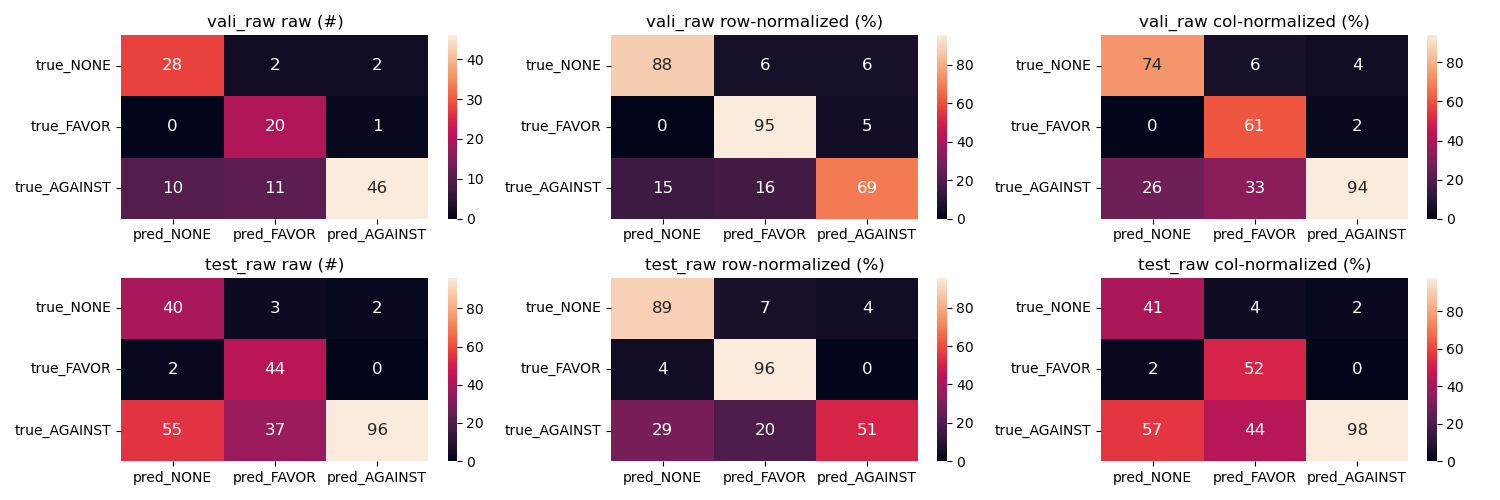

In [19]:
display_resized_image_in_notebook(join(PATH_OUTPUT_ROOT,"summary","chatgpt_turbo_3_5_few_shot_comb_confusion_mat.png"))

As shown in the test set confusion matrices, the model demonstrates proficiency in distinguishing between the `FAVOR` and `NONE` stances. However, it faces challenges in accurately predicting the `AGAINST` stance, frequently misclassifying them as `NONE`.

Now, let's examine the confusion matrix for the CoT prompt, which has the worst macro-F1 score.

The confusion matrices below reveal that the model has a strong tendency to predict the `NONE` stance, which is defined as the stance being neutral or unclear. It seems like after reasoning step by step, the model tends to reach a conclusion that the stance is not clear.

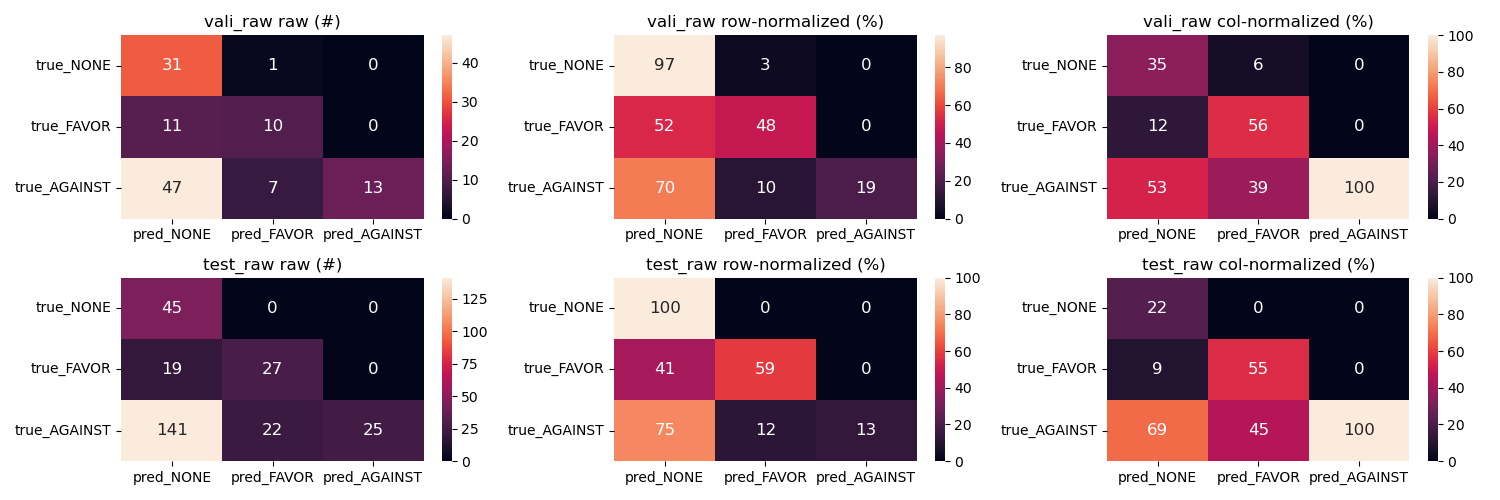

In [20]:
display_resized_image_in_notebook(join(PATH_OUTPUT_ROOT,"summary","chatgpt_turbo_3_5_CoT_comb_confusion_mat.png"))

****

# Feed the prompts to FLAN-T5 models

Great! Now we know that ChatGPT with few-shot prompts outperforms fine-tuned BERT on this dataset. This is promising because prompting the LLM doesn't require a large amount of labeled data for training. However, one notable downside is that using ChatGPT incurs a monetary cost.

Next, let's explore if the open-source FLAN-T5 can achieve similar results.

First, you have to decide whether you want to prompt FLAN-T5 on your own.

I recommend keeping `PROMPT_FLAN_T5 = False` (the default setting below) if you are running this notebook for the first time. This will read the predictions I made and uploaded to my GitHub repo, which will save you time.

If you want to try it out on your own, you can set `PROMPT_CHAT_GPT = True` and run the code below. If you are running this on Google Colab, make sure you have use the GPU run time. To do this, go to `Runtime` -> `Change runtime type` -> `Hardware accelerator` -> `GPU`. This will ensure that the note will run more efficiently and quickly.


In [ ]:
PROMPT_FLAN_T5 = False

In [204]:
%load_ext autoreload
%autoreload 2
from gpt_predict_label import FlanT5LargeLabelPredictor, FlanT5XxlLabelPredictor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helpfer function

In [205]:
def prompt_flan_t5(model_type, prompt_version):
    # get the output paths
    # model_type_name = tidy_name(model_type)
    path_output = join(PATH_OUTPUT_ROOT, model_type, prompt_version)
    file_output_predictions = join(path_output, "predictions.csv")

    gpt_data_processor = SemEvalGPTDataProcessor(version_prompt=prompt_version, topic=TOPIC_OF_INTEREST)
    
    # create the prompt, which is the input to the LLMs
    df_input_text = gpt_data_processor.embed_prompt(file_output=None, write_csv=False,
                                                    return_df=True)

    # partition the data into train, vali, test (note that we only need the vali and test set in this approach)
    dict_df_single_domain = partition_and_resample_df(
        df_input_text, seed=None, partition_type="single_domain",
        read_partition_from_df=True,
        df_partitions=df_partitions)

    # select the partition to be labeled
    # - vali and test
    df_input_text_filtered = pd.DataFrame()
    for partition in ["vali_raw", "test_raw"]:
        df_input_text_filtered = pd.concat([df_input_text_filtered, dict_df_single_domain[partition]])

    df_input_text = df_input_text_filtered

    # specify the output type (single-word or multi-word)
    if prompt_version in ["zero_shot","few_shot"]:
        mode_output = "single-word"
    elif prompt_version == "CoT":
        mode_output = "CoT"

    if model_type == "flan-t5-large":
        llm_label_predictor = FlanT5LargeLabelPredictor(col_name_text="tweet_embedded",
                                                        col_name_label="stance_predicted",
                                                        col_name_text_id=par.TEXT_ID,
                                                        try_use_gpu=True,
                                                        per_device_eval_batch_size=16,
                                                        mode_output=mode_output,
                                                        for_generation_only=True)
    elif model_type == "flan-t5-xxl":
        llm_label_predictor = FlanT5XxlLabelPredictor(col_name_text="tweet_embedded",
                                                        col_name_label="stance_predicted",
                                                        col_name_text_id=par.TEXT_ID,
                                                        try_use_gpu=True,
                                                        per_device_eval_batch_size=16,
                                                        mode_output=mode_output,
                                                        for_generation_only=True)        
    else:
        raise ValueError("model_type not supported")

    # prompt the LLM to make predictions (write the predictions to `file_output_predictions`)
    llm_label_predictor.predict_labels(df_input_text,
                                       file_output_predictions,
                                       keep_tweet_id=True, keep_text=False,
                                       output_prob_mode=None,
                                       list_label_space=None,
                                       col_name_tweet_id=par.TEXT_ID)


## Use the zero-shot and few-shot prompts

Note that as mentioned earlier, zero-shot CoT prompt only works when the LLM has more than 100 billion parameters. Even the larges variant of FLAN-T5 (`flan-t5-xxl`) has only 11 billion parameters, so we will not use the zero-shot CoT prompt in this tutorial.

In [206]:
model_type = "flan-t5-large"
if PROMPT_FLAN_T5:
    for prompt_version in ["zero_shot","few_shot"]:
        print("model:{}, prompt version: {}".format(model_type, prompt_version))
        prompt_flan_t5(model_type, prompt_version)

model:flan-t5-large, prompt version: zero_shot
model:flan-t5-large, prompt version: few_shot


While FLAN-T5-XXL is the most powerful variant, it can not be run on Google Colab due to GPU memory limitations. In this tutorial, I have run the predictions elsewhere and upload the predictions. If you want to prompt FLAN-T5-XXL on your own and you have access to a large GPU with more memory (>30GB), you can prompt the FLAN-T5-XXL model by setting `LARGE_GPU_AVAILABLE = True` below.

In [207]:
# run this only if use you a large enough GPU (>30GB)
LARGE_GPU_AVAILABLE = False
if LARGE_GPU_AVAILABLE and PROMPT_FLAN_T5:
    model_type = "flan-t5-xxl"
    for prompt_version in ["zero_shot","few_shot"]:
        print("model:{}, prompt version: {}".format(model_type, prompt_version))
        prompt_flan_t5(model_type, prompt_version)

### View the predictions

In [208]:
def read_predictions(model_type, prompt_version):
    # get the output paths
    # model_type_name = tidy_name(model_type)
    path_output = join(PATH_OUTPUT_ROOT, model_type, prompt_version)
    file_output_predictions = join(path_output, "predictions.csv")

    # read the predictions
    df_predictions = pd.read_csv(file_output_predictions)
    return df_predictions

As demonstrated below, using a zero-shot prompt, the FLAN-T5-XXL model successfully predicts the stance of this example tweet, whereas the FLAN-T5-Large model struggles to do so.

In [209]:
df_predictions_flan_xxl_zero_shot = read_predictions("flan-t5-xxl","zero_shot")
df_predictions_flan_large_zero_shot = read_predictions("flan-t5-large","zero_shot")

In [210]:
# view the first prediction
print("prompt:\n{}\n".format(df_predictions_flan_xxl_zero_shot["tweet_embedded"][0]))
# print("ID:\n{}\n".format(df_predictions_flan_xxl_zero_shot["ID"][0]))
print("true label::\n{}\n".format(df_input_text[df_input_text["ID"]=="2313"][["label"]].values[0][0].lower()))

print("FLAN-T5-LARGE's prediction:\n{}".format(df_predictions_flan_large_zero_shot["stance_predicted"][0]))
print("FLAN-T5-XXL's prediction:\n{}".format(df_predictions_flan_xxl_zero_shot["stance_predicted"][0]))

prompt:
What is the stance of the tweet below with respect to 'Legalization of Abortion'?  If we can infer from the tweet that the tweeter supports 'Legalization of Abortion', please label it as 'in-favor'. If we can infer from the tweet that the tweeter is against 'Legalization of Abortion', please label is as 'against'. If we can infer from the tweet that the tweeter has a neutral stance towards 'Legalization of Abortion', please label it as 'neutral-or-unclear'. If there is no clue in the tweet to reveal the stance of the tweeter towards 'Legalization of Abortion', please also label is as 'neutral-or-unclear'. Please use exactly one word from the following 3 categories to label it: 'in-favor', 'against', 'neutral-or-unclear'. Here is the tweet. 'let's agree that it's not ok to kill a 7lbs baby in the uterus @USERNAME #dnc #clinton2016 @USERNAME #procompromise' The stance of the tweet is: 

true label::
against

FLAN-T5-LARGE's prediction:
in-favor
FLAN-T5-XXL's prediction:
against


## Evaluate the Predictions of Different Prompts and Different Models

Fantastic! With the predictions in hand from two types of prompts and two variants of FLAN-T5 models, it's time to evaluate their performance across all tweets in both the validation and test sets.

In [211]:
evaluate("flan-t5-large", "zero_shot")
evaluate("flan-t5-large", "few_shot")
# although you may not have run the xxl model due to GPU contraint, you can still evaluate the results because I have already run the model elsewhere and saved the predictions
evaluate("flan-t5-xxl", "zero_shot")
evaluate("flan-t5-xxl", "few_shot")

In [212]:
# sumamrize the result acrpss different models and prompt versions
# - also visualize the confusion matrices
df_hightlight_metrics_flan_t5 = summarize_results(["flan-t5-large","flan-t5-xxl"],["zero_shot","few_shot"])

df_hightlight_metrics_flan_t5 = df_hightlight_metrics_flan_t5[df_hightlight_metrics_flan_t5.model_type.isin(["llm_flan-t5-large","llm_flan-t5-xxl"])]

# reorder the rows
df_hightlight_metrics_flan_t5['model_type'] = pd.Categorical(df_hightlight_metrics_flan_t5['model_type'], categories=["llm_flan-t5-large","llm_flan-t5-xxl"], ordered=True)
df_hightlight_metrics_flan_t5['version'] = pd.Categorical(df_hightlight_metrics_flan_t5['version'], categories=["zero_shot","few_shot"], ordered=True)
df_hightlight_metrics_flan_t5 = df_hightlight_metrics_flan_t5.sort_values(by=["model_type","version"]).reset_index(drop=True)

# rename columns
df_hightlight_metrics_flan_t5 = df_hightlight_metrics_flan_t5[["model_type","version","set","f1_macro","f1_NONE","f1_FAVOR","f1_AGAINST"]].sort_values(by=["model_type","version"]).rename(columns={"version":"prompt_type","set":"partition"})

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

### View the performance on the validation set

In [213]:
df_hightlight_metrics_flan_t5_vali = df_hightlight_metrics_flan_t5[df_hightlight_metrics_flan_t5["partition"].isin(["vali_raw"])]

# convert "vali_raw" to "vali" (in the partition column)
df_hightlight_metrics_flan_t5_vali.loc[df_hightlight_metrics_flan_t5_vali["partition"]=="vali_raw","partition"] = "vali"

df_hightlight_metrics_flan_t5_vali

,model_type,prompt_type,partition,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
0,llm_flan-t5-large,zero_shot,vali,0.244478,0.060606,0.215686,0.457143
2,llm_flan-t5-large,few_shot,vali,0.267255,0.060606,0.192771,0.548387
4,llm_flan-t5-xxl,zero_shot,vali,0.693311,0.600000,0.653846,0.826087
6,llm_flan-t5-xxl,few_shot,vali,0.680935,0.653846,0.603774,0.785185


The first two columns indicate the model type and the prompt type, respectively. The third column indicates that the performance is evaluated on the validation set. The `f1_macro` column indicates the macro-averaged F1 score (across the three stance types). We use this value to quantify the overall performance of the model. Note that we are using the `f1_macro` metric rather than accuracy because the dataset is imbalanced, and the `f1_macro` metric is more robust to imbalanced datasets.

Based on the macro-F1 scores, the larger FLAN-T5-XXL model performs better than the smaller FLAN-T5-Large model across two prompt types. This is expected because the larger model has more parameters and can capture more subtle meanings in language.

For FLAN-T5-XXL model, using few-shot prompt does not seem to help.

The last 3 columns indicate the performance of each stance type. This shows that the model is better at predicting the `AGAINST` stance than the `NONE` and `FAVOR` stances.


> Note that, in practice, to avoid data leakage, when selecting the best combination of prompt type and model type, we should use the performance on the validation set to choose the best combination, and then use the performance on the test set to evaluate the final model.

> To learn more about macro-F1 score, I recommend taking a look at this tutorial https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#:~:text=The%20macro%2Daveraged%20F1%20score,regardless%20of%20their%20support%20values.

### View the performance on the test set

In [214]:
df_hightlight_metrics_flan_t5_test = df_hightlight_metrics_flan_t5[df_hightlight_metrics_flan_t5["partition"].isin(["test_raw"])]

# convert "test_raw" to "test" (in the partition column)
df_hightlight_metrics_flan_t5_test.loc[df_hightlight_metrics_flan_t5_test["partition"]=="test_raw","partition"] = "test"

df_hightlight_metrics_flan_t5_test

,model_type,prompt_type,partition,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
1,llm_flan-t5-large,zero_shot,test,0.212933,0.043478,0.181034,0.414286
3,llm_flan-t5-large,few_shot,test,0.278003,0.083333,0.198953,0.551724
5,llm_flan-t5-xxl,zero_shot,test,0.619033,0.583333,0.531250,0.742515
7,llm_flan-t5-xxl,few_shot,test,0.591850,0.534653,0.519685,0.721212


The results are similar to the validation set. The larger FLAN-T5-XXL model performs better than the smaller FLAN-T5-Large model across two prompt types. For FLAN-T5-XXL model, using few-shot prompt does not seem to help.

### Confusion Matrix

As we did for ChatGPT, let's examine the confusion matrix for best performing combination of model and prompt (i.e., FLAN-T5-XXL with zero-shot prompt).

Similar to ChatGPT with few-shot prompt (the best combination for ChatGPT), the FLAN-T5-XXL model also has trouble classifying the tweets with the `AGAINST` stance, misclassifying them as either `FAVOR` or `NONE`. In addition, the model also misclassifies some `FAVOR` and `NONE` tweets as `AGAINST`. These collectivly result in a lower macro-F1 score than ChatGPT with few-shot prompt.

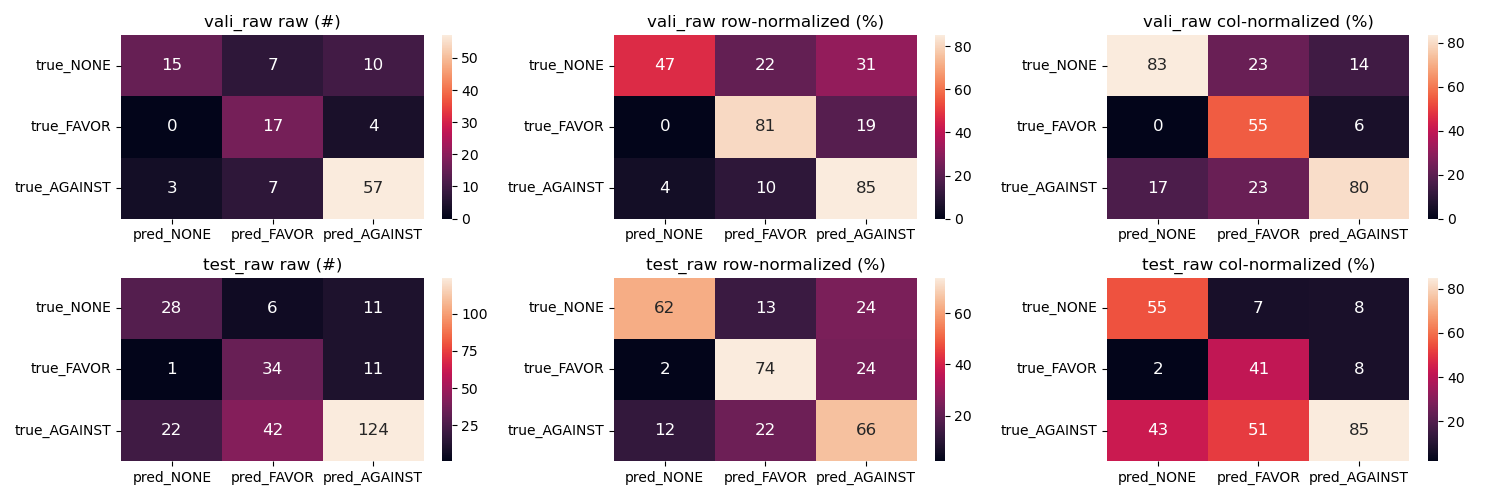

In [22]:
display_resized_image_in_notebook(join(PATH_OUTPUT_ROOT,"summary","flan-t5-xxl_zero_shot_comb_confusion_mat.png"))

### Compare FLAN-T5 with BERT

Let's compare the performance of FLAN-T5 with BERT. The results of BERT are generated from the previous tutorial.

In [223]:
df_hightlight_metrics_bert = pd.read_csv(join(par.PATH_RESULT_SEM_EVAL_TUNING,"summary","metrics_highlights.csv"))
df_hightlight_metrics_bert = df_hightlight_metrics_bert[["version","set","f1_macro","f1_NONE","f1_FAVOR","f1_AGAINST"]].rename(columns={"version":"model_type"})
# reorder the rows
df_hightlight_metrics_bert['model_type'] = pd.Categorical(df_hightlight_metrics_bert['model_type'], categories=["bert-base-uncased","vinai_bertweet_base","kornosk_polibertweet_mlm"], ordered=True)
df_hightlight_metrics_bert = df_hightlight_metrics_bert.sort_values(by=["model_type"]).reset_index(drop=True)
# rename columns
df_hightlight_metrics_bert = df_hightlight_metrics_bert.rename(columns={"set":"partition"})
# convert "test_raw" to "test" (in the partition column)
df_hightlight_metrics_bert.loc[df_hightlight_metrics_bert["partition"]=="test_raw","partition"] = "test"
# subset the test set
df_hightlight_metrics_bert_test = df_hightlight_metrics_bert[df_hightlight_metrics_bert["partition"]== "test"]
df_hightlight_metrics_bert_test

,model_type,partition,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
2,bert-base-uncased,test,0.4549,0.4060,0.4056,0.5532
5,vinai_bertweet_base,test,0.4933,0.4507,0.4741,0.5552
8,kornosk_polibertweet_mlm,test,0.5200,0.4848,0.4697,0.6054


Based on the macro-F1 scores, the FLAN-T5-XXL model using the zero-shot prompt outperforms all the BERT variants we examined in the previous tutorial.

****

# Compare ChatGPT with FLAN-T5 and BERT on the test set

In [224]:
df_hightlight_metrics_llm_test = \
  pd.concat([df_hightlight_metrics_flan_t5_test , df_hightlight_metrics_chatgpt_test],
           axis=0)

df_hightlight_metrics_llm_test.sort_values(by=["f1_macro"],ascending=False).reset_index(drop=True)

,model_type,prompt_type,partition,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
0,llm_chatgpt_turbo_3_5,few_shot,test,0.637211,0.563380,0.676923,0.671329
1,llm_flan-t5-xxl,zero_shot,test,0.619033,0.583333,0.531250,0.742515
2,llm_flan-t5-xxl,few_shot,test,0.591850,0.534653,0.519685,0.721212
3,llm_chatgpt_turbo_3_5,zero_shot,test,0.507138,0.435644,0.672269,0.413502
4,llm_chatgpt_turbo_3_5,CoT,test,0.387721,0.360000,0.568421,0.234742
5,llm_flan-t5-large,few_shot,test,0.278003,0.083333,0.198953,0.551724
6,llm_flan-t5-large,zero_shot,test,0.212933,0.043478,0.181034,0.414286


In [222]:
# bert
df_hightlight_metrics_bert.sort_values(by=["f1_macro"],ascending=False).reset_index(drop=True)

,model_type,partition,f1_macro,f1_NONE,f1_FAVOR,f1_AGAINST
0,kornosk_polibertweet_mlm,test,0.5200,0.4848,0.4697,0.6054
1,vinai_bertweet_base,test,0.4933,0.4507,0.4741,0.5552
2,bert-base-uncased,test,0.4549,0.4060,0.4056,0.5532


The results of the comparison between ChatGPT, FLAN-T5, and BERT models across different prompts show that the prompting approach can outperform a fine-tuned BERT, even when considering domain-specific pretrained models like kornosk_polibertweet_mlm and vinai_bertweet_base. 

ChatGPT with few-shot prompts achieves the highest macro-F1 scores on the test set, followed by FLAN-T5-XXL with zero-shot and few-shot prompts. Notably, even the open-source large language model, FLAN-T5, reaches decent performance, offering a cost-effective alternative to ChatGPT. However, it's important to note that using FLAN-T5 requires access to GPUs with about 30GB of memory to handle its large size. 

These large language models with prompting strategies deliver better performance than the fine-tuned BERT variants, including domain-specific models and bert-base-uncased. This demonstrates the potential of using prompts with large language models, as they offer competitive performance without requiring extensive labeled data for training.

> Notes for advanced readers: It's worth noting that the one advantage of fine-tuning BERT is that its performance increases as the amount of training labeled data increases. This is not the case for large language models with prompting strategies, as the number of examples you can fit in a prompt is limited. To ensure that the performance of the prompting approach benefits from more training data, you can also fine-tune an LLM on a large amount of labeled data. For more information, the bonus section below.

****

# Conclusions

In conclusion, this tutorial has demonstrated how to implement stance detection using ChatGPT and FLAN-T5 on the Abortion dataset. We've explored the use of different prompt types and compared their performance to BERT-based models, including domain-specific pre-trained models. The results show that prompting large language models, like ChatGPT and FLAN-T5, can outperform fine-tuned BERT models in this task, even without extensive labeled data for training. However, it's essential to consider the trade-offs, such as the monetary cost of using ChatGPT and the memory requirements for utilizing FLAN-T5. 

****

## Bonus for eager readers

In addition to using prompting strategies with large language models, it's worth noting that fine-tuning LLMs is another viable approach to improve their performance on specific tasks, including stance detection. By fine-tuning an LLM on a task-specific dataset, the model can adapt to the nuances of the data, better understand the domain-specific language, and potentially yield higher performance. 

OpenAI has an [guide on how to fine-tune GPT-3](https://platform.openai.com/docs/guides/fine-tuning) on a specific task. It is also possible to fine-tune open-source LLMs like FLAN-T5 for specific tasks. For example, [this tutorial](https://medium.com/google-cloud/fine-tuning-flan-t5-xxl-with-deepspeed-and-vertex-ai-af499daf694d) demonstrates how to fine-tune FLAN-T5 for text classification. One caveat is that fine-tuning LLMs, like fine-tuning a BERT model, also requires a large amount of labeled data for training. 

Another caveat is that fine-tining the GPT-3 model and using a fine-tuned model can be expensive. Please see the [OpenAI's pricing page](https://openai.com/pricing) for more details. On the other hand, [fine-tuning FLAN-T5-XXL is GPU intensive](https://medium.com/google-cloud/fine-tuning-flan-t5-xxl-with-deepspeed-and-vertex-ai-af499daf694d) and requires about 680GB of GPU memory and few days of training time.